# Proyecto: análisis de cancelación de compra en tienda online (notebook de trabajo)

### Índice
1. **Créditos y atribuciones**

2. **Objetivo**

3. **Carga y procesamiento inicial del conjunto de datos**

4. **Análisis exploratorio de datos (EDA)**<br>
4.1. _Cálculo de la tasa de abandono_<br>
4.2. _Análisis por períodos de tiempo_<br>
4.3. _Análisis del comportamiento del cliente_<br>
4.4. _Modelo de Random Forest para descubrir patrones de comportamiento_<br>
4.5. _Modelo de regresión logística_

### Créditos y atribuciones:

> @article {Requena2020,<br>
> author = {Requena, Borja and Cassani, Giovanni and Tagliabue, Jacopo and Greco, Ciro and Lacasa, Lucas},<br>
> title = {Shopper intent prediction from clickstream e-commerce data with minimal browsing information},<br>
> year = {2020},<br>
> journal = {Scientific Reports},<br>
> pages   = {2045-2322},<br>
> volume  = {10},<br>
> doi = {10.1038/s41598-020-73622-y}<br>
> }

Los datos crudos provienen de un [estudio](https://www.nature.com/articles/s41598-020-73622-y.epdf?sharing_token=tydJezcxTZvP8cNEDsAKn9RgN0jAjWel9jnR3ZoTv0NoB1nwg3Wgf_mP0ktAdV_HGxUxXaNdBCErP1Zck0ibhFGwRrt0xq-Uy2wNz5DkwbFN44Mxzwb3WdN593RbqBFNucB9hEgd3EFvTZaqO9reUDDlh-mybSw5d1-G04RfdBQ%3D) publicado en la revista _Scientific Reports_ en 2020. El objetivo de este era determinar si una sesión de navegación de un usuario terminará en una compra. La descripción de las columnas del dataset, proporcionada por los autores, es la siguiente:

<img src="Data_description.png" alt="Descripcion de los datos" width="500" height="300"/>

### Objetivo:
Podemos aprovechar este conjunto de datos para realizar un **análisis de abandono del carrito de compra**. Se busca comprender con qué frecuencia y por qué razones los usuarios terminan abandonando sus intenciones de compra. Intentaremos averigüar qué acciones puede tomar la compañía para disminuir la tasa de abandono.

### Carga y procesamiento inicial del conjunto de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter
import ast
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('release_10_23_2020.csv')
df.head(5)

,session_id_hash,event_type,product_action,product_skus_hash,server_timestamp_epoch_ms,hashed_url
0,00000005c19449b57d8d05dfc8b5474be0654032,pageview,NaN,NaN,1544469996111,da99729886aff70a02733b6cd69ee7df35622d9302347e...
1,00006a0ada94a5186163a25e9ed9c94481c820d9,pageview,NaN,NaN,1545737959865,e2f7e0cee4272e804f0d323a3513dd01716a5a40ab9abf...
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908835402,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908847263,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,90add4dd072e160034e98ddea257e0b59441eae00d8955...,1544909035879,8fa1ecf31ececb27ebe9c529966f3d1f907542fe138d5d...


In [3]:
print(df.shape)
# Verificar nulos y duplicados
print(df.isnull().sum())
df.drop_duplicates(inplace=True)

(5433611, 6)
session_id_hash                    0
event_type                         0
product_action               2918789
product_skus_hash            3547557
server_timestamp_epoch_ms          0
hashed_url                         0
dtype: int64


In [4]:
print(df.shape)

(5387057, 6)


Sabemos, por la información del conjunto de datos proporcionada arriba, que en la columna _product action_, un valor NaN indica una simple visualización de página. Cambiaremos el valor NaN a 'pageview' para dafle lógica a la secuencia de eventos, lo que nos facilitará el trabajo de analizar las mismas.

In [5]:
df['product_action'] = df['product_action'].replace(np.nan, 'pageview')
df['product_action'] = df['product_action'].replace('pageview', None)
df['product_skus_hash'] = df['product_skus_hash'].replace('pageview', np.nan)
df.head()

,session_id_hash,event_type,product_action,product_skus_hash,server_timestamp_epoch_ms,hashed_url
0,00000005c19449b57d8d05dfc8b5474be0654032,pageview,None,NaN,1544469996111,da99729886aff70a02733b6cd69ee7df35622d9302347e...
1,00006a0ada94a5186163a25e9ed9c94481c820d9,pageview,None,NaN,1545737959865,e2f7e0cee4272e804f0d323a3513dd01716a5a40ab9abf...
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,None,NaN,1544908835402,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,None,NaN,1544908847263,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,90add4dd072e160034e98ddea257e0b59441eae00d8955...,1544909035879,8fa1ecf31ececb27ebe9c529966f3d1f907542fe138d5d...


In [6]:
# verificación nulos y duplicados después de la limpieza
print(df.isnull().sum())

session_id_hash                    0
event_type                         0
product_action               2918712
product_skus_hash            3501035
server_timestamp_epoch_ms          0
hashed_url                         0
dtype: int64


In [7]:
# procesamiento de la columna server_timestamp_epoch_ms para convertirla en una columna de tipo datetime
df['Event time'] = pd.to_datetime(df['server_timestamp_epoch_ms'], unit='ms')

# ordenamiento por sesión y tiempo
df.sort_values(by=['session_id_hash', 'Event time'], inplace=True)

### Análisis exploratorio de datos (EDA)

Trabajaremos en el conjunto de datos para determinar la tasa de abandono del carrito de compra, visualizar qué días y a qué horas se da el mayor número de desechos de compra, así como intentar comprender el flujo de acción que sigue un usuario que descarta la compra al último momento, con el fin de extraer conclusiones informativas (_insights_) que podamos traducir en mejoras empresariales.

In [8]:
# búsqueda de tipos de evento que nos indiquen compra o agregar a carrito
print(df['event_type'].value_counts())
print()
print(df['product_action'].value_counts())

event_type
pageview    4565160
event        821897
Name: count, dtype: int64

product_action
detail      1640174
add          696912
click         69830
remove        51503
purchase       9926
Name: count, dtype: int64


In [9]:
# agrupamiento por sesión y de concatenación los eventos
events = df.groupby('session_id_hash').agg({
    'event_type':list, 
    'product_action':list,
    'Event time':list
}).reset_index()

events.head(4)

,session_id_hash,event_type,product_action,Event time
0,00000005c19449b57d8d05dfc8b5474be0654032,[pageview],[None],[2018-12-10 19:26:36.111000]
1,00006a0ada94a5186163a25e9ed9c94481c820d9,[pageview],[None],[2018-12-25 11:39:19.865000]
2,00007d15aeb741b3cdd873cb3933351d699cc320,"[pageview, pageview, pageview, pageview, pagev...","[None, None, detail, None, detail, None, detail]","[2018-12-15 21:20:35.402000, 2018-12-15 21:20:..."
3,0000c49d1359c87f112285d63a9fc0d4c50f73b4,"[pageview, pageview, pageview]","[None, None, None]","[2018-12-14 09:43:49.084000, 2018-12-14 09:44:..."


In [10]:
# función para determinar si un evento es de abandono
def is_abandoned(product_actions):
    added = False
    for action in product_actions:
        if action == 'add':
            added = True
        elif action == 'remove':
            added = False
        elif action == 'purchase':
            return False
    return added

events['abandoned_cart'] = events.apply(
    lambda row: is_abandoned(row['product_action']), axis=1)

In [11]:
# verificación de la función imprimiendo el nuevo dataframe
events.head()

,session_id_hash,event_type,product_action,Event time,abandoned_cart
0,00000005c19449b57d8d05dfc8b5474be0654032,[pageview],[None],[2018-12-10 19:26:36.111000],False
1,00006a0ada94a5186163a25e9ed9c94481c820d9,[pageview],[None],[2018-12-25 11:39:19.865000],False
2,00007d15aeb741b3cdd873cb3933351d699cc320,"[pageview, pageview, pageview, pageview, pagev...","[None, None, detail, None, detail, None, detail]","[2018-12-15 21:20:35.402000, 2018-12-15 21:20:...",False
3,0000c49d1359c87f112285d63a9fc0d4c50f73b4,"[pageview, pageview, pageview]","[None, None, None]","[2018-12-14 09:43:49.084000, 2018-12-14 09:44:...",False
4,0001135282dbaf0e734345212ea6f8da9f5b66ed,[pageview],[None],[2018-12-10 06:16:32.886000],False


#### Cálculo de la tasa de abandono

In [12]:
# cálculo de la tasa de abandono
AbandonedSessions = events['abandoned_cart'].sum()
TotalSessions = events.shape[0]
AbandonedRate = AbandonedSessions / TotalSessions * 100
print(f'Tasa de abandono del carrito: {round(AbandonedRate, 5)} %')

Tasa de abandono del carrito: 6.16441 %


#### Análisis por períodos de tiempo

In [13]:
# creación de un nuevo dataframe que aísla solo las sesiones abandonadas
AbandonedEvents = events[events['abandoned_cart']==True]
AbandonedEvents.head(3)

,session_id_hash,event_type,product_action,Event time,abandoned_cart
22,00045455b4141ae8c3b03574149c0cc45d66e9cd,"[pageview, pageview, event, pageview, pageview...","[None, detail, add, None, detail, None, detail...","[2018-12-18 09:50:17.932000, 2018-12-18 09:50:...",True
24,0005074ab7bb7ee4d64eeef81355d73c04a82863,"[pageview, pageview, pageview, pageview, pagev...","[None, None, detail, None, detail, None, detai...","[2018-12-14 17:10:09.663000, 2018-12-14 17:10:...",True
29,000611028b5b7d332c9127face3eebb84e046591,"[pageview, pageview, pageview, pageview, pagev...","[detail, detail, detail, None, None, detail, a...","[2018-12-18 19:32:16.414000, 2018-12-18 19:32:...",True


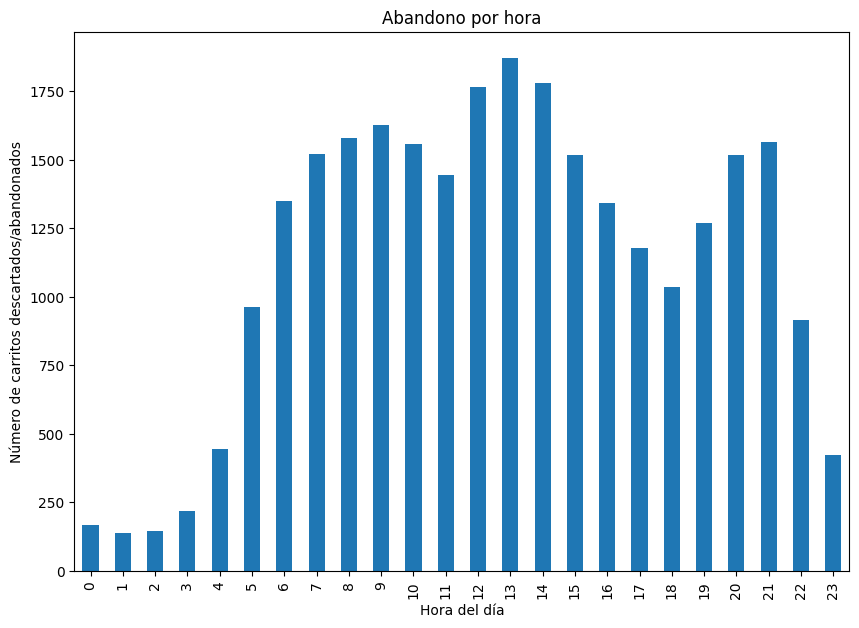

In [14]:
# Hora del último evento en sesiones abandonadas
AbandonedEvents['Last_event_time'] = AbandonedEvents['Event time'].apply(lambda x: x[-1])
AbandonedEvents['Hour'] = pd.to_datetime(AbandonedEvents['Last_event_time']).dt.hour
AbandonedEvents['Hour'] = AbandonedEvents['Last_event_time'].dt.hour

abandoned_by_hour = AbandonedEvents.groupby('Hour').size()

# graficación de la tasa de abandono por hora
abandoned_by_hour.plot(kind='bar', figsize=(10,7), title='Abandono por hora')
plt.xlabel('Hora del día')
plt.ylabel('Número de carritos descartados/abandonados')
plt.show()

Se puede observar que la mayor parte de los eventos de abandono se dan alrededor del mediodía o a las 13:00 horas de la tarde.

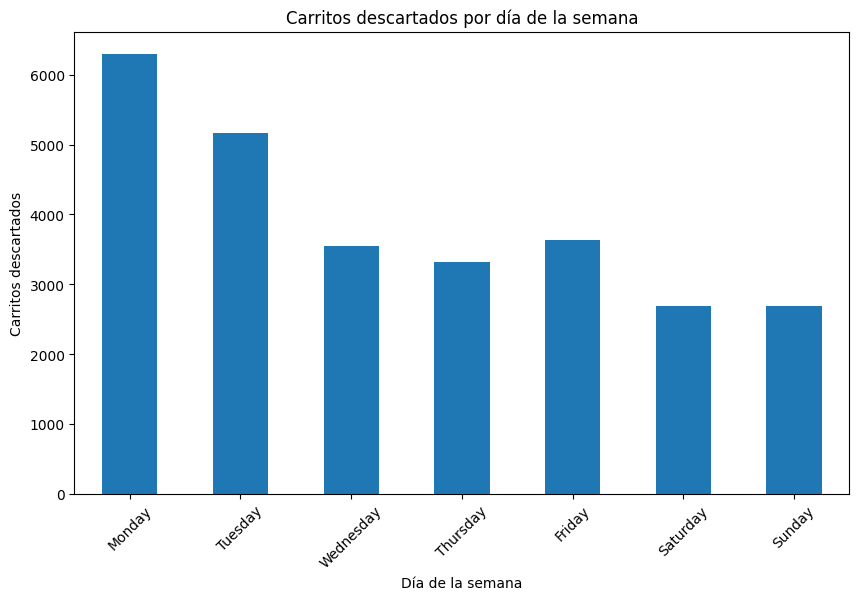

In [15]:
AbandonedEvents['Event time'] = AbandonedEvents['Event time'].apply(lambda x: x[0] if isinstance(x, list) else x)
AbandonedEvents['Event time'] = pd.to_datetime(AbandonedEvents['Event time'])
AbandonedEvents['DayOfWeek'] = AbandonedEvents['Event time'].dt.day_name()

abandonment_by_day = AbandonedEvents.groupby('DayOfWeek').size()
abandonment_by_day = abandonment_by_day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 6))
abandonment_by_day.plot(kind='bar')
plt.xlabel('Día de la semana')
plt.ylabel('Carritos descartados')
plt.title('Carritos descartados por día de la semana')
plt.xticks(rotation=45)
plt.show()

Los lunes parecen ocurrir más eventos de abandono y el número disminuye progresivamente, con ligeros repuntes los viernes y domingos.

#### Análisis de comportamiento del cliente

In [16]:
# conversión de listas de eventos en tuplas para hacerlas contables
AbandonedEvents['event_type_tuple'] = AbandonedEvents['event_type'].apply(tuple)
AbandonedEvents['product_action_tuple'] = AbandonedEvents['product_action'].apply(tuple)

# agrupación de secuencias de eventos y concatenación
event_sequences = AbandonedEvents.groupby('session_id_hash')['event_type_tuple'].sum()
product_sequences = AbandonedEvents.groupby('session_id_hash')['product_action_tuple'].sum()

# conteo de frecuencia y ordenamiento
event_sequence_counts = Counter(event_sequences)
product_sequence_counts = Counter(product_sequences)
common_event_sequences = event_sequence_counts.most_common(10)
common_product_sequences = product_sequence_counts.most_common(10)

**Secuencias de eventos más comunes antes del abandono de compra:**


In [17]:
# ''event_type'' resultados
for seq, count in common_event_sequences:
    print(f"La secuencia {seq} ocurrió {count} veces")

La secuencia ('pageview', 'event') ocurrió 299 veces
La secuencia ('pageview', 'event', 'pageview') ocurrió 151 veces
La secuencia ('pageview', 'pageview', 'pageview', 'event') ocurrió 135 veces
La secuencia ('pageview', 'pageview', 'pageview', 'event', 'pageview') ocurrió 124 veces
La secuencia ('pageview', 'event', 'pageview', 'pageview') ocurrió 115 veces
La secuencia ('pageview', 'pageview', 'pageview', 'pageview', 'event', 'pageview') ocurrió 113 veces
La secuencia ('pageview', 'pageview', 'pageview', 'event', 'pageview', 'pageview', 'pageview') ocurrió 110 veces
La secuencia ('pageview', 'pageview', 'event', 'pageview') ocurrió 107 veces
La secuencia ('pageview', 'pageview', 'pageview', 'pageview', 'event') ocurrió 106 veces
La secuencia ('pageview', 'pageview', 'pageview', 'event', 'pageview', 'pageview') ocurrió 98 veces


**Secuencias de acción de producto más comunes antes del abandono de compra:**

In [18]:
# ''product_action'' resultados
for seq, count in common_product_sequences:
    print(f"La secuencia {seq} ocurrió {count} veces")

La secuencia ('detail', 'add') ocurrió 299 veces
La secuencia ('detail', 'add', None) ocurrió 94 veces
La secuencia (None, None, 'detail', 'add') ocurrió 92 veces
La secuencia (None, None, 'detail', 'add', None) ocurrió 78 veces
La secuencia (None, None, None, 'detail', 'add', None) ocurrió 69 veces
La secuencia (None, 'detail', 'add', None) ocurrió 69 veces
La secuencia (None, None, None, 'detail', 'add') ocurrió 68 veces
La secuencia ('add',) ocurrió 64 veces
La secuencia ('detail', 'add', 'detail') ocurrió 57 veces
La secuencia (None, 'detail', 'add') ocurrió 55 veces


Esta información parece sugerir que la mayoría de los eventos donde se descarta finalmente la compra o no se realiza en principio, el cliente **no encuentra algo que lo convenza** (existen demasiados eventos de visualización sin ninguna acción por parte del comprador). Es notable también el hecho de que los carritos descartados no suelen tener más de **un solo producto**: la secuencia de acción de producto más frecuente es 'detail' --> 'add' (visualizar los detalles de un ítem específico y agregarlo) solo una vez; no vemos secuencias más largas de 'detail' y 'add' consecutivas, ni varias acciones 'add' en cadena.

#### Modelo de Random Forest para descubrir patrones de comportamiento

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, precision_recall_curve
)
from sklearn.metrics import f1_score

In [20]:
def convert_to_datetime_list(event_time_str):
    if isinstance(event_time_str, list):
        return [pd.to_datetime(ts) for ts in event_time_str]
    else:
        event_time_list = ast.literal_eval(event_time_str)
        return [pd.to_datetime(ts) for ts in event_time_list]

events['Event time'] = events['Event time'].apply(convert_to_datetime_list)

In [21]:
events["session_duration"] = events["Event time"].apply(lambda x: (max(x) - min(x)).seconds)  
events["hour"] = events["Event time"].apply(lambda x: x[0].hour)  # Hora del primer evento
events["day_of_week"] = events["Event time"].apply(lambda x: x[0].dayofweek)  # Día de la semana del primer evento
events.drop(columns=["Event time"], inplace=True)

events.head()

,session_id_hash,event_type,product_action,abandoned_cart,session_duration,hour,day_of_week
0,00000005c19449b57d8d05dfc8b5474be0654032,[pageview],[None],False,0,19,0
1,00006a0ada94a5186163a25e9ed9c94481c820d9,[pageview],[None],False,0,11,1
2,00007d15aeb741b3cdd873cb3933351d699cc320,"[pageview, pageview, pageview, pageview, pagev...","[None, None, detail, None, detail, None, detail]",False,499,21,5
3,0000c49d1359c87f112285d63a9fc0d4c50f73b4,"[pageview, pageview, pageview]","[None, None, None]",False,253,9,4
4,0001135282dbaf0e734345212ea6f8da9f5b66ed,[pageview],[None],False,0,6,0


In [22]:
# conteo de veces de cada tipo de evento
mlb_event = MultiLabelBinarizer()
event_encoded = pd.DataFrame(mlb_event.fit_transform(df['event_type']), columns=['event_' + e for e in mlb_event.classes_])
df = pd.concat([df, event_encoded], axis=1)

# conteo de veces de cada acción de producto
df['product_action'] = df['product_action'].apply(lambda x: x if isinstance(x, list) else [])

mlb_action = MultiLabelBinarizer()
action_encoded = pd.DataFrame(
    mlb_action.fit_transform(df['product_action']),
    columns=["action_" + str(a) for a in mlb_action.classes_]
)

df = pd.concat([df, action_encoded], axis=1)
df.drop(columns=['product_action'], inplace=True)


In [23]:
# agregar características para los productos
events['num_events'] = events['event_type'].apply(len)  # número total de eventos en la sesión
events['num_product_actions'] = events['product_action'].apply(lambda x: sum(a is not None for a in x))  # número de interacciones con productos

In [24]:
# revisión de la última acción realizada en la sesión
events['last_action'] = events['product_action'].apply(lambda x: x[-1] if x and x[-1] is not None else "None")
events = pd.get_dummies(events, columns=['last_action'], drop_first=True)  # <--- codificación One-hot 
events = pd.get_dummies(events, columns=['day_of_week'], prefix='day') # <--- codificación One-hot a los días de la semana


In [25]:
events.head()

,session_id_hash,event_type,product_action,abandoned_cart,session_duration,hour,num_events,num_product_actions,last_action_add,last_action_click,last_action_detail,last_action_purchase,last_action_remove,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,00000005c19449b57d8d05dfc8b5474be0654032,[pageview],[None],False,0,19,1,0,False,False,False,False,False,True,False,False,False,False,False,False
1,00006a0ada94a5186163a25e9ed9c94481c820d9,[pageview],[None],False,0,11,1,0,False,False,False,False,False,False,True,False,False,False,False,False
2,00007d15aeb741b3cdd873cb3933351d699cc320,"[pageview, pageview, pageview, pageview, pagev...","[None, None, detail, None, detail, None, detail]",False,499,21,7,3,False,False,True,False,False,False,False,False,False,False,True,False
3,0000c49d1359c87f112285d63a9fc0d4c50f73b4,"[pageview, pageview, pageview]","[None, None, None]",False,253,9,3,0,False,False,False,False,False,False,False,False,False,True,False,False
4,0001135282dbaf0e734345212ea6f8da9f5b66ed,[pageview],[None],False,0,6,1,0,False,False,False,False,False,True,False,False,False,False,False,False


In [26]:
events.drop(columns=["event_type", "product_action", "session_id_hash"], inplace=True)
events.head()

,abandoned_cart,session_duration,hour,num_events,num_product_actions,last_action_add,last_action_click,last_action_detail,last_action_purchase,last_action_remove,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,False,0,19,1,0,False,False,False,False,False,True,False,False,False,False,False,False
1,False,0,11,1,0,False,False,False,False,False,False,True,False,False,False,False,False
2,False,499,21,7,3,False,False,True,False,False,False,False,False,False,False,True,False
3,False,253,9,3,0,False,False,False,False,False,False,False,False,False,True,False,False
4,False,0,6,1,0,False,False,False,False,False,True,False,False,False,False,False,False


**Entrenamiento del modelo Random Forest:**

In [27]:
# definición de las variables predictora y dependiente
X = events.drop(columns=["abandoned_cart"])
y = events["abandoned_cart"].astype(int)

# conjuntos de entrenamiento y prueba 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
# creacion del modelo y ajuste
rf_model = RandomForestClassifier(
    class_weight="balanced",
    max_depth=15,
    min_samples_leaf=5,
    min_samples_split=20,
    n_estimators=100,
    random_state=24,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=5, min_samples_split=20, n_jobs=-1,
                       random_state=24)

**Predicción y evaluación del modelo:**

In [29]:
y_proba = rf_model.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.1, 0.9, 50)
best_threshold = 0.5
best_f1 = 0
for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh
y_pred_adj = (y_proba >= best_threshold).astype(int)


Matriz de confusión:

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     83262
           1       0.35      0.60      0.44      5470

    accuracy                           0.91     88732
   macro avg       0.66      0.76      0.70     88732
weighted avg       0.93      0.91      0.92     88732


ROC-AUC score: 0.922


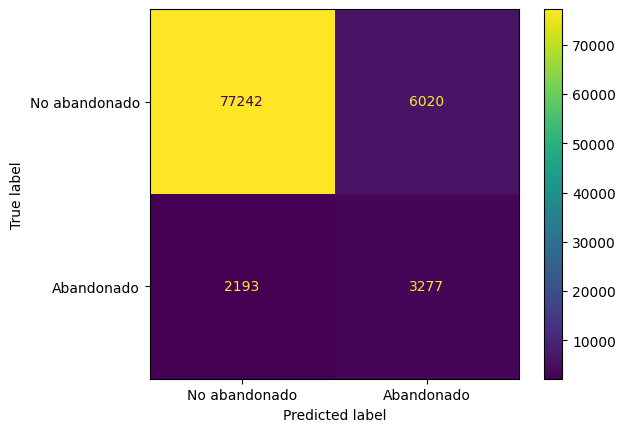

In [30]:
print('Matriz de confusión:')
conf_mtx = confusion_matrix(y_test, y_pred_adj)
cf_plot = ConfusionMatrixDisplay(conf_mtx, display_labels=['No abandonado', 'Abandonado'])
cf_plot.plot()
print()

print('Reporte de clasificación:')
print(classification_report(y_test, y_pred_adj))
print()

print('ROC-AUC score:', round(roc_auc_score(y_test, y_proba),3))

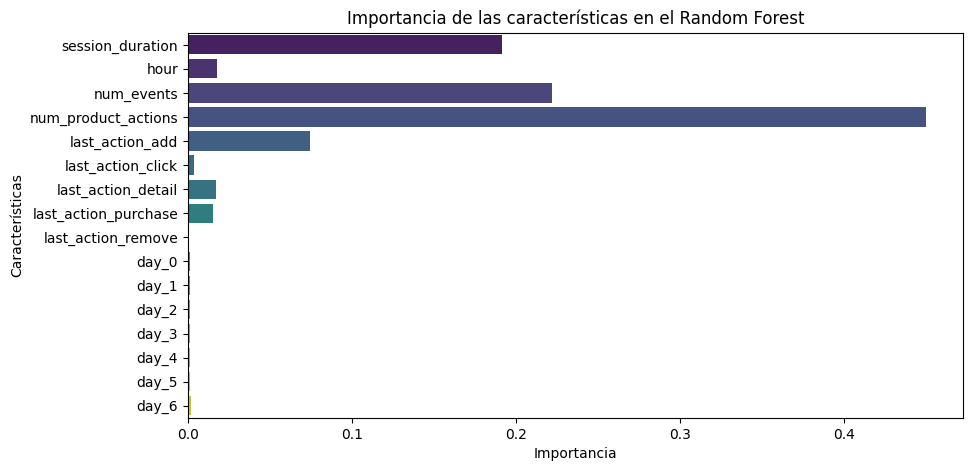

In [31]:
# importancia por características
importances = rf_model.feature_importances_
features = X.columns

# gráficas de evaluación
plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=features, palette='viridis')
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de las características en el Random Forest")
plt.show()

Como se puede observar, el modelo es bueno evaluando los carritos que no fueron abandonados (clase 0), con una precisión del 97 %. Sin embargo, el modelo alcanza apenas una exactitud del 60 % para los casos de las compras que **SÍ** fueron descartadas. Intentaremos usar una **regresión logística** para evaluar qué tan bien se ajusta este a los datos.

#### Modelo de regresión logística

In [32]:
X = events.drop(columns=['abandoned_cart'])
y = events["abandoned_cart"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
# estandarización de las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
# modelo
lr_model = LogisticRegression(
    class_weight="balanced",  
    solver="liblinear",       
    random_state=42,
    max_iter=1000             
)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

In [35]:
# predicciones
y_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# umbrales
thresholds = np.linspace(0.1, 0.9, 50)
best_f1 = 0
best_threshold = 0.5

for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh
   
   # predicciones ajustadas     
y_pred_adj = (y_proba >= best_threshold).astype(int)

Confusion Matrix:

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     83262
           1       0.34      0.52      0.41      5470

    accuracy                           0.91     88732
   macro avg       0.65      0.73      0.68     88732
weighted avg       0.93      0.91      0.92     88732


AUC-ROC Score: 0.90


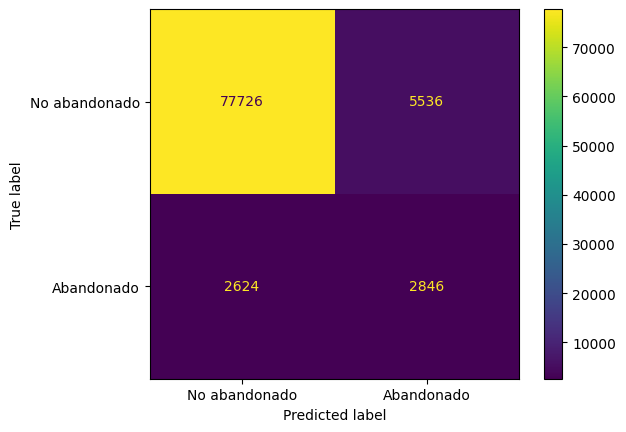

In [36]:
    # evaluación
print("Confusion Matrix:")
cf_mat_2 = confusion_matrix(y_test, y_pred_adj)
cf_plot_2 = ConfusionMatrixDisplay(cf_mat_2, display_labels=['No abandonado', 'Abandonado'])
cf_plot_2.plot()
print()

print('Reporte de clasificación:')
print(classification_report(y_test, y_pred_adj))
print()

print(f"AUC-ROC Score: {roc_auc_score(y_test, y_proba):.2f}")

                 Feature  Coefficient
2             num_events     1.992007
4        last_action_add     0.591954
0       session_duration     0.367675
12                 day_3     0.033880
11                 day_2     0.030436
13                 day_4     0.025183
10                 day_1     0.014456
9                  day_0     0.012273
3    num_product_actions     0.009136
1                   hour    -0.017482
6     last_action_detail    -0.026880
14                 day_5    -0.042393
5      last_action_click    -0.053911
15                 day_6    -0.075675
8     last_action_remove    -0.309484
7   last_action_purchase    -9.839679


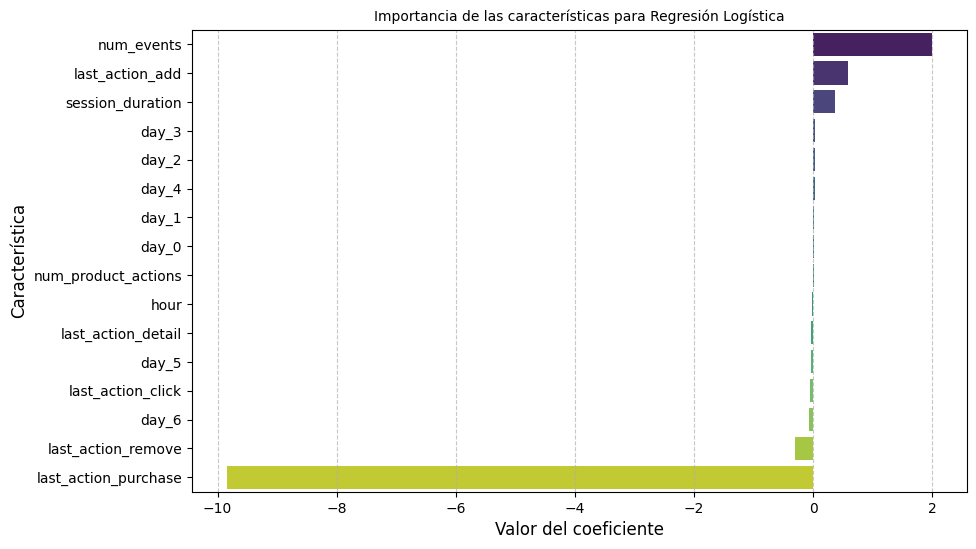

In [37]:
    # evaluación de importancia de caracteristicas

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
print(feature_importance)

    # graficar
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=feature_importance,
    palette='viridis'
)
plt.title('Importancia de las características para Regresión Logística', fontsize=10)
plt.xlabel('Valor del coeficiente', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()